In [1]:

import torchvision
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'dml'

In [2]:
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision import transforms

path = os.path.join('dataset', 'samples')

class CatDogDataset(Dataset):
    def __init__(self, path, is_test=False):
        files = glob(os.path.join(path, '*.jpg'))
        from random import shuffle
        shuffle(files)
        test_offset = int(len(files) * 0.8)
        self.files = files[test_offset:] if is_test else files[:test_offset]

        self.transform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # shuffle data
        # targets
        pos = len(path)+1
        # cat 1 dog 0
        self.targets = [fpath[pos:pos+3] == 'cat' for fpath in self.files]
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        target = self.targets[idx]
        im = (cv2.imread(f)[:,:,::-1])
        # resize into 224x224
        im = cv2.resize(im, (224,224)) 
        # into range 0 ~ 1
        im = torch.tensor(im/255)
        # change dim channel, width, height
        im = im.permute(2,0,1)
        # normalize
        im = self.transform(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)
    

In [3]:
train_data = CatDogDataset(path)
test_data = CatDogDataset(path, is_test=True)
print(len(train_data), len(test_data))

20000 5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


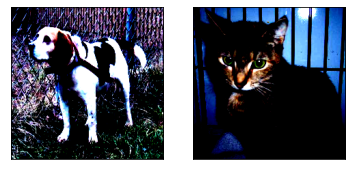

In [40]:
import matplotlib.pyplot as plt

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img.permute(1,2,0).cpu())
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show([train_data[30][0], train_data[12530][0]])


In [4]:
def tl_model():
    model = torchvision.models.resnet18(pretrained=True)
    # fix the parameters
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    return model.to(device)
    

In [5]:
from torchsummary import summary
model = tl_model()
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [46]:
LR = 0.001
NUM_EPOCH = 8


# adam 
model = tl_model()
optim = Adam(model.parameters(), lr=LR)
loss = nn.BCELoss()

In [47]:
# prepare the dataset
train = CatDogDataset(path)
dl_train = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
val = CatDogDataset(path, is_test=True)
dl_val = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)

In [48]:
def train(x, y, model, optim, loss):
    model.train()
    optim.zero_grad()
    pred = model(x)
    l = loss(pred , y)
    l.backward()
    optim.step()
    return l.item()

def eval(x, y, model):
    model.eval()
    pred = model(x)
    is_correct = (pred > 0.5) == y
    # return avg accuracy
    return is_correct.cpu().numpy()



train_loss, train_accuracy, val_accuracy = [], [], []

for e in range(NUM_EPOCH):
    e_train_losses, e_train_accuracies, e_val_accuracies = [], [], []

    # train
    for x, y in iter(dl_train):
        e_loss = train(x, y, model, optim, loss)
        e_train_losses.append(e_loss)
    e_train_loss = np.mean(e_train_losses)
    train_loss.append(e_train_loss)

    # eval with train
    for x, y in iter(dl_train):
        correction = eval(x, y, model)
        e_train_accuracies.append(correction)
    e_train_accuracy = np.mean(e_train_accuracies)
    train_accuracy.append(e_train_accuracy)

    # eval
    for x, y in iter(dl_val):
        correction = eval(x, y, model)
        e_val_accuracies.append(correction)
    e_val_accuracy = np.mean(e_val_accuracies)
    val_accuracy.append(e_val_accuracy)
    print(f"Epoch {e+1}/{NUM_EPOCH}, train_loss : {e_train_loss}, train_acc : {e_train_accuracy}, val_acc : {e_val_accuracy}")
    


Epoch 1/8, train_loss : 0.1131156203713268, train_acc : 0.97845, val_acc : 0.9795673076923077
Epoch 2/8, train_loss : 0.08568875536695122, train_acc : 0.9784, val_acc : 0.977363782051282
Epoch 3/8, train_loss : 0.0778482649460435, train_acc : 0.98375, val_acc : 0.9837740384615384
Epoch 4/8, train_loss : 0.07107970814127475, train_acc : 0.98505, val_acc : 0.985176282051282
Epoch 5/8, train_loss : 0.0681970189936459, train_acc : 0.9846, val_acc : 0.985176282051282
Epoch 6/8, train_loss : 0.0641599464142695, train_acc : 0.98605, val_acc : 0.9857772435897436
Epoch 7/8, train_loss : 0.06351424938272685, train_acc : 0.9878, val_acc : 0.9887820512820513
Epoch 8/8, train_loss : 0.06355081418789923, train_acc : 0.98705, val_acc : 0.9879807692307693


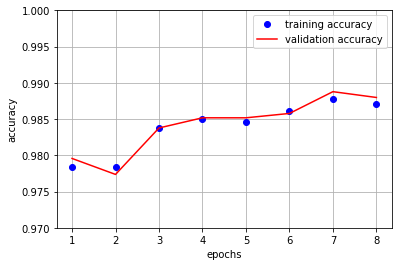

In [52]:
plot_x = np.arange(NUM_EPOCH)+1
plt.plot(plot_x, train_accuracy, 'bo', label='training accuracy')
plt.plot(plot_x, val_accuracy, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0.97,1)
plt.legend()
plt.grid('off')
plt.show()